In [14]:
from typing import Callable, List, Tuple

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from simulated_annealing.algorithm import simple_simulated_annealing
from simulated_annealing.experiment_utils import shape_progress, shuffle
from simulated_annealing.tsp_neighbors import generate_2opt_neighbor, generate_2swap_neighbor

REPS = 10
SEEDS = np.random.randint(200, size=10)

# Experiments

In [26]:
def generate_path_distance_computer(fp: str) -> Tuple[Callable[[List[int]], float], int]:
    data = np.loadtxt(fp)
    n = data.shape[0]

    def compute_pd(path: List[int]) -> float:
        return np.sum([data[path[i], path[(i + 1) % n]] for i in range(n)])

    return compute_pd, n


def experiment(data_set: str,
               nbr: Callable[[List[int]], List[int]],
               name: str,
               max_iters=10_000,
               seeds=np.random.randint(100, size=REPS),
               temp_factor=0.95,
               initial_temp=10_000) -> pd.DataFrame:
    obj_f, n = generate_path_distance_computer(data_set)
    results = []

    for i in range(REPS):
        np.random.seed(seeds[i])
        s0 = shuffle([i for i in range(n)])
        results.append(
            simple_simulated_annealing(obj_f, nbr, s0,
                                       temp_factor=temp_factor,
                                       initial_temperature=initial_temp,
                                       max_iterations=max_iters)
        )

    df = pd.concat([shape_progress(r, i) for i, r in enumerate(results)])
    df["Type"] = name
    df["$T_0$"] = str(initial_temp)
    return df


def plot(df: pd.DataFrame, optimal: float) -> Tuple[plt.Figure, Tuple]:
    plot_figure, (a1, a2, a3) = plt.subplots(3, 1, figsize=(15, 15))
    sns.lineplot(df, x="Iteration", y="Acceptance rate", hue="$T_0$", errorbar="sd", ax=a1)
    a2.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Current cost", hue="Type", style="$T_0$", errorbar="sd", ax=a2)
    a3.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Best cost", hue="Type", style="$T_0$", errorbar="sd", ax=a3)

    return plot_figure, (a1, a2, a3)


def plot_wo_error(df: pd.DataFrame, optimal: float) -> Tuple[plt.Figure, Tuple]:
    plot_figure, (a1, a2) = plt.subplots(2, 1, figsize=(15, 10))
    a1.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Current cost", style="Type", hue="$T_0$", errorbar=None, ax=a1)
    a2.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Best cost", style="Type", hue="$T_0$", errorbar=None, ax=a2)

    return plot_figure, (a1, a2)

In [16]:
%%time
gr17_maxi = 1500
gr17_data = [
    experiment("data/gr17_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=gr17_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=gr17_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=gr17_maxi, initial_temp=10_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=gr17_maxi, initial_temp=10_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=gr17_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=gr17_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=gr17_maxi, initial_temp=100, seeds=SEEDS),
    experiment("data/gr17_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=gr17_maxi, initial_temp=100, seeds=SEEDS),
]
gr17_df = pd.concat(gr17_data)
gr17_df.to_csv("results/sa_gr17.csv", index=False)

CPU times: user 2.25 s, sys: 12.3 ms, total: 2.26 s
Wall time: 2.26 s


In [17]:
%%time
fri26_maxi = 2500
fri26_data = [
    experiment("data/fri26_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=fri26_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=fri26_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=fri26_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=fri26_maxi, initial_temp=10_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=fri26_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=fri26_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=fri26_maxi, initial_temp=100, seeds=SEEDS),
    experiment("data/fri26_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=fri26_maxi, initial_temp=100, seeds=SEEDS),
]
fri26_df = pd.concat(fri26_data)
fri26_df.to_csv("results/sa_fri26.csv", index=False)

CPU times: user 4.05 s, sys: 43.5 ms, total: 4.09 s
Wall time: 4.07 s


In [18]:
%%time
att48_maxi = 5000
att48_data = [
    experiment("data/att48_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=att48_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=att48_maxi, initial_temp=50_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=att48_maxi, initial_temp=10_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=att48_maxi, initial_temp=10_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=att48_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=att48_maxi, initial_temp=1_000, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2swap_neighbor, "SA 2-swap",
               max_iters=att48_maxi, initial_temp=100, seeds=SEEDS),
    experiment("data/att48_d.txt", generate_2opt_neighbor, "SA 2-opt",
               max_iters=att48_maxi, initial_temp=100, seeds=SEEDS),
]
att48_df = pd.concat(att48_data)
att48_df.to_csv("results/sa_att48.csv", index=False)

CPU times: user 9.59 s, sys: 152 ms, total: 9.75 s
Wall time: 9.69 s


/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

CPU times: user 12 s, sys: 184 ms, total: 12.2 s
Wall time: 11.2 s


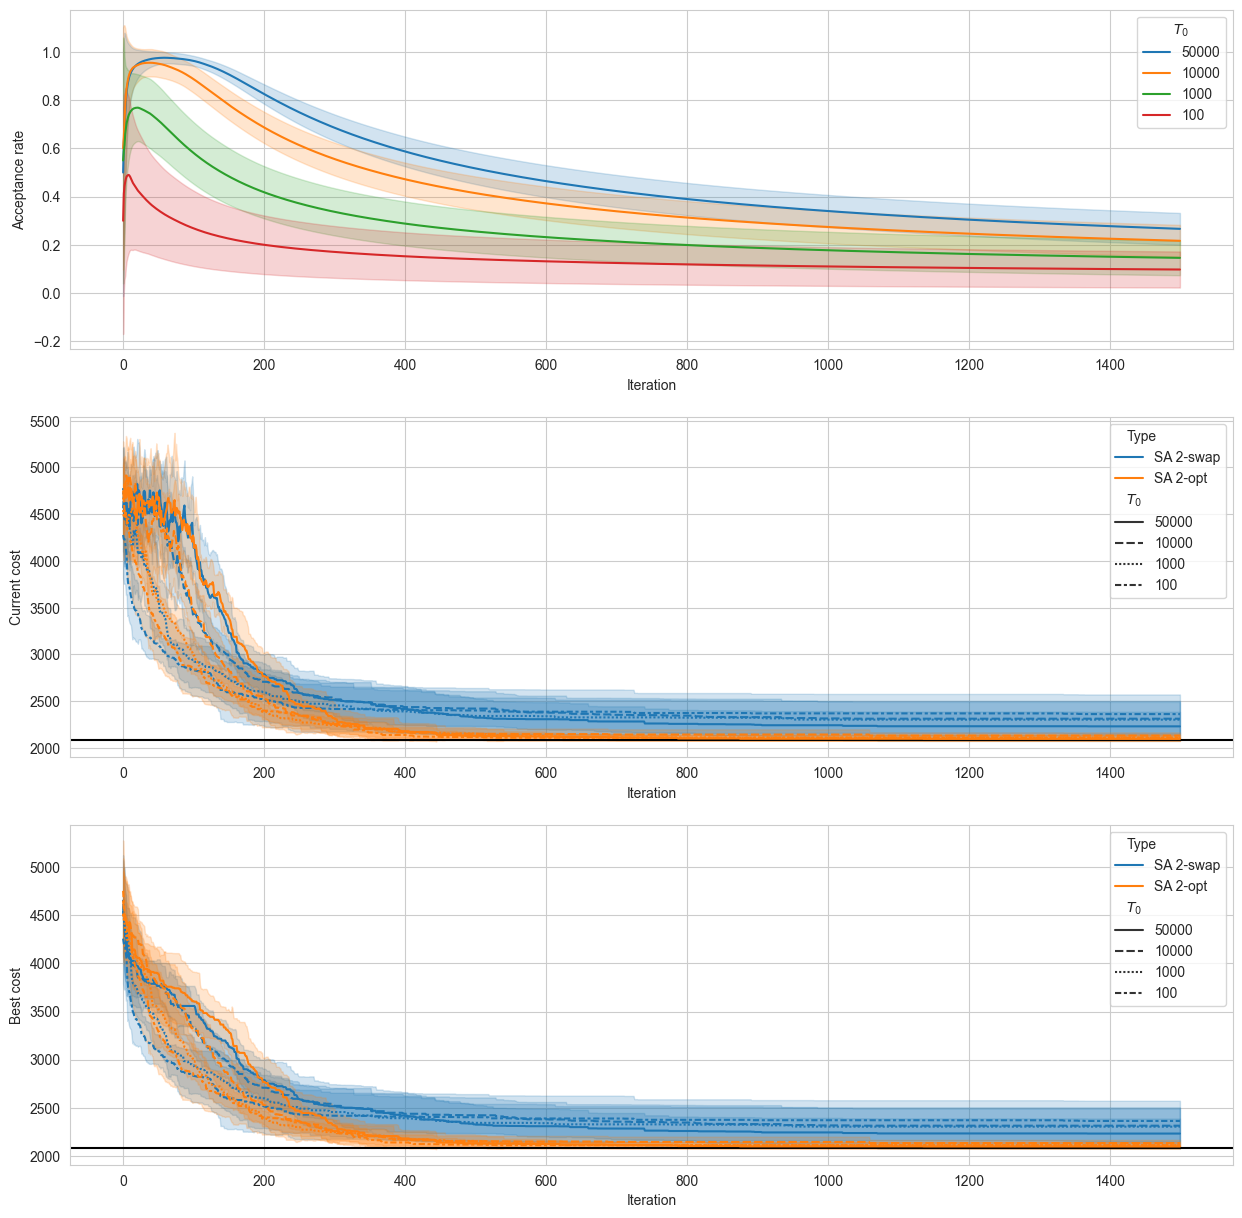

In [19]:
%%time
gr17_fig, _ = plot(gr17_df, 2085)
gr17_fig.savefig("../images/gr17_sa", dpi=600, bbox_inches="tight")

/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

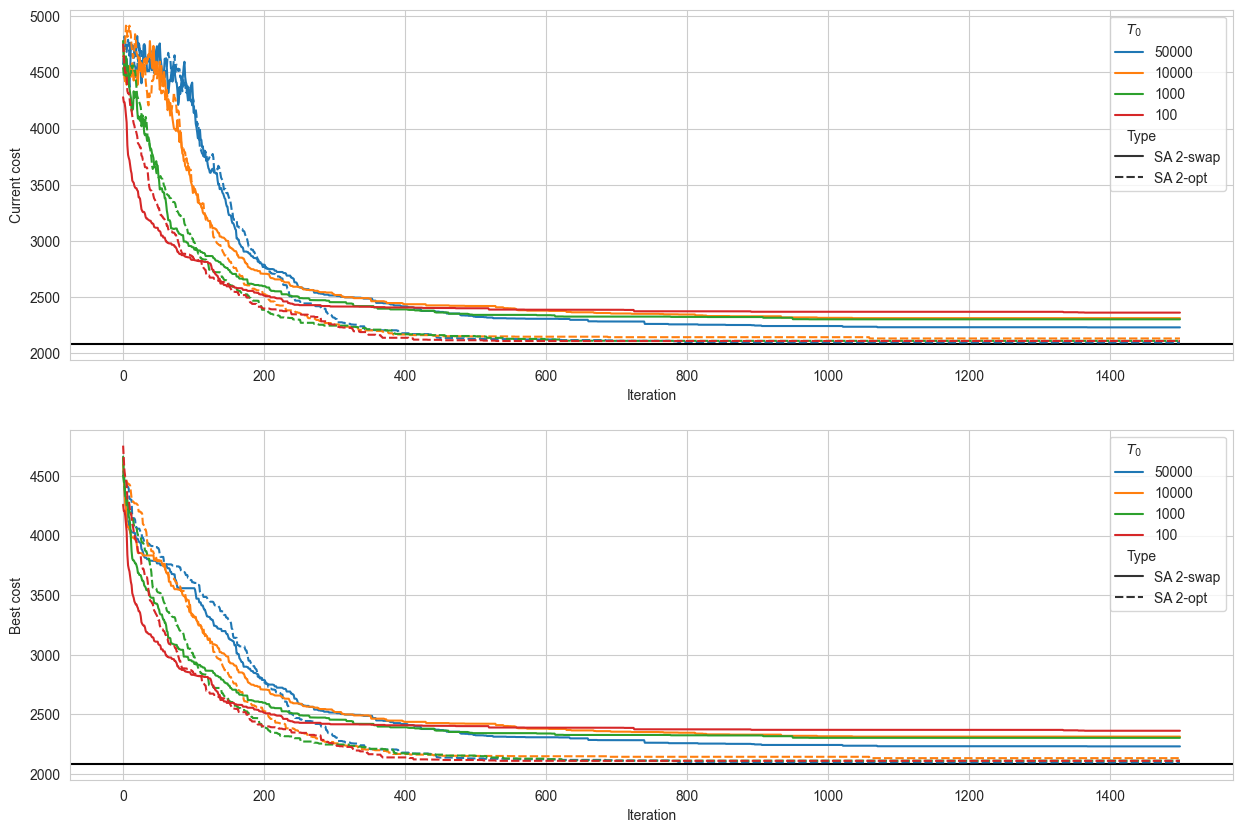

In [27]:
gr17_ne, _ = plot_wo_error(gr17_df, 2085)
gr17_ne.savefig("../images/gr17-no-error.png", dpi=600, bbox_inches="tight")

/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

CPU times: user 14.9 s, sys: 159 ms, total: 15.1 s
Wall time: 14 s


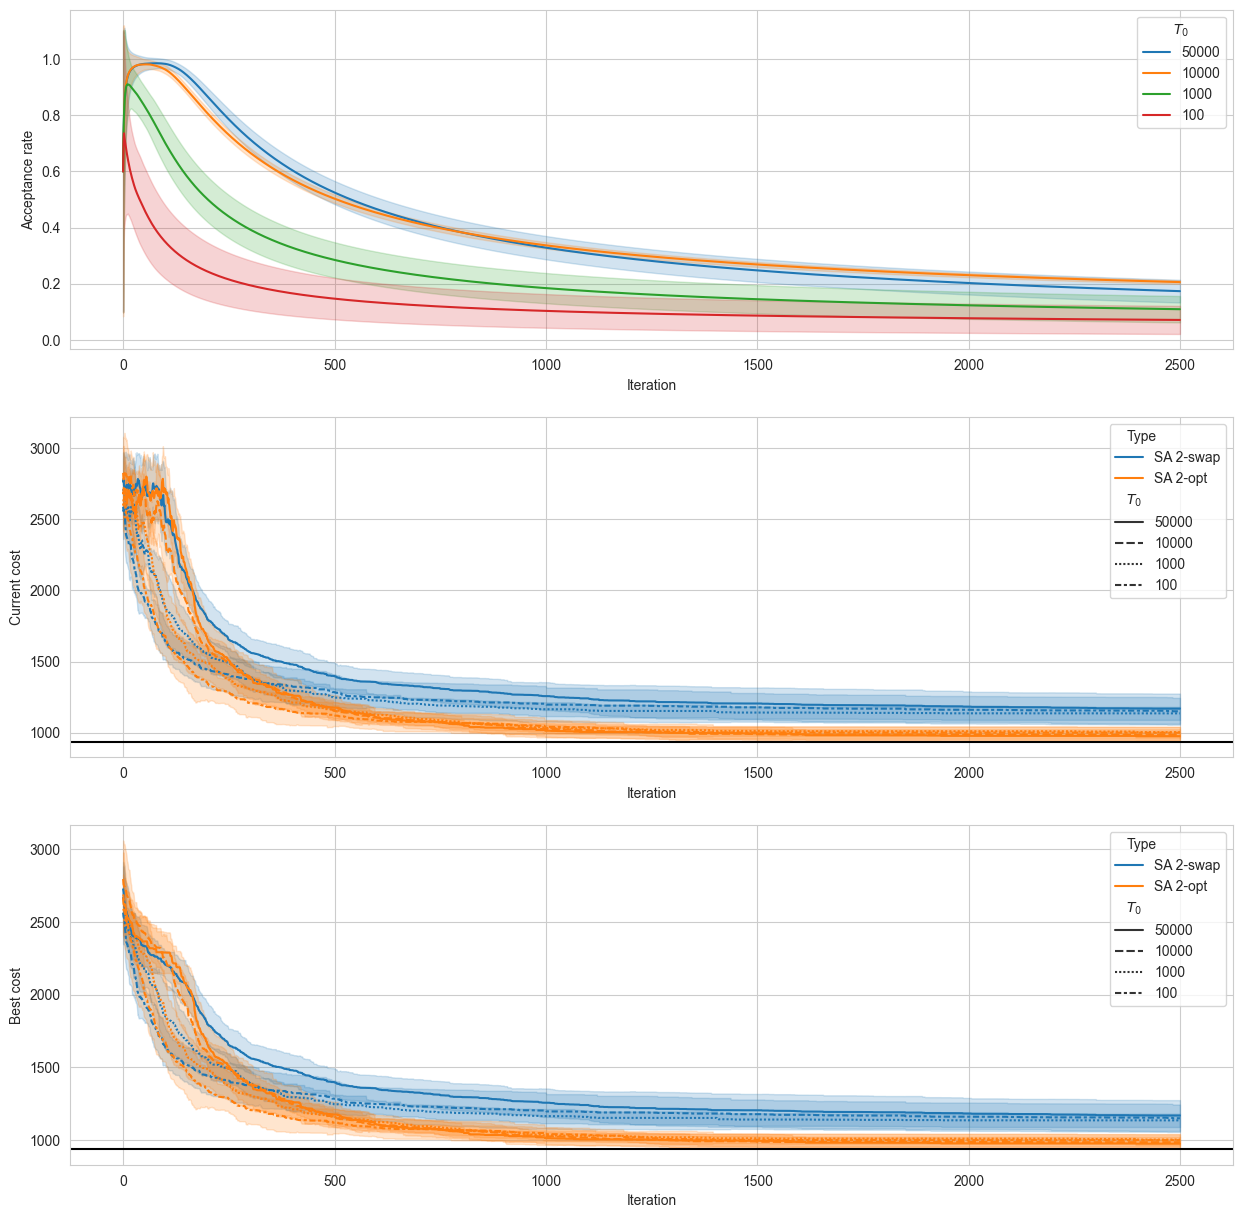

In [21]:
%%time
fri26_fig, _ = plot(fri26_df, 937)
fri26_fig.savefig("../images/fri26_sa", dpi=600, bbox_inches="tight")

/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

CPU times: user 10.1 s, sys: 116 ms, total: 10.2 s
Wall time: 9.15 s


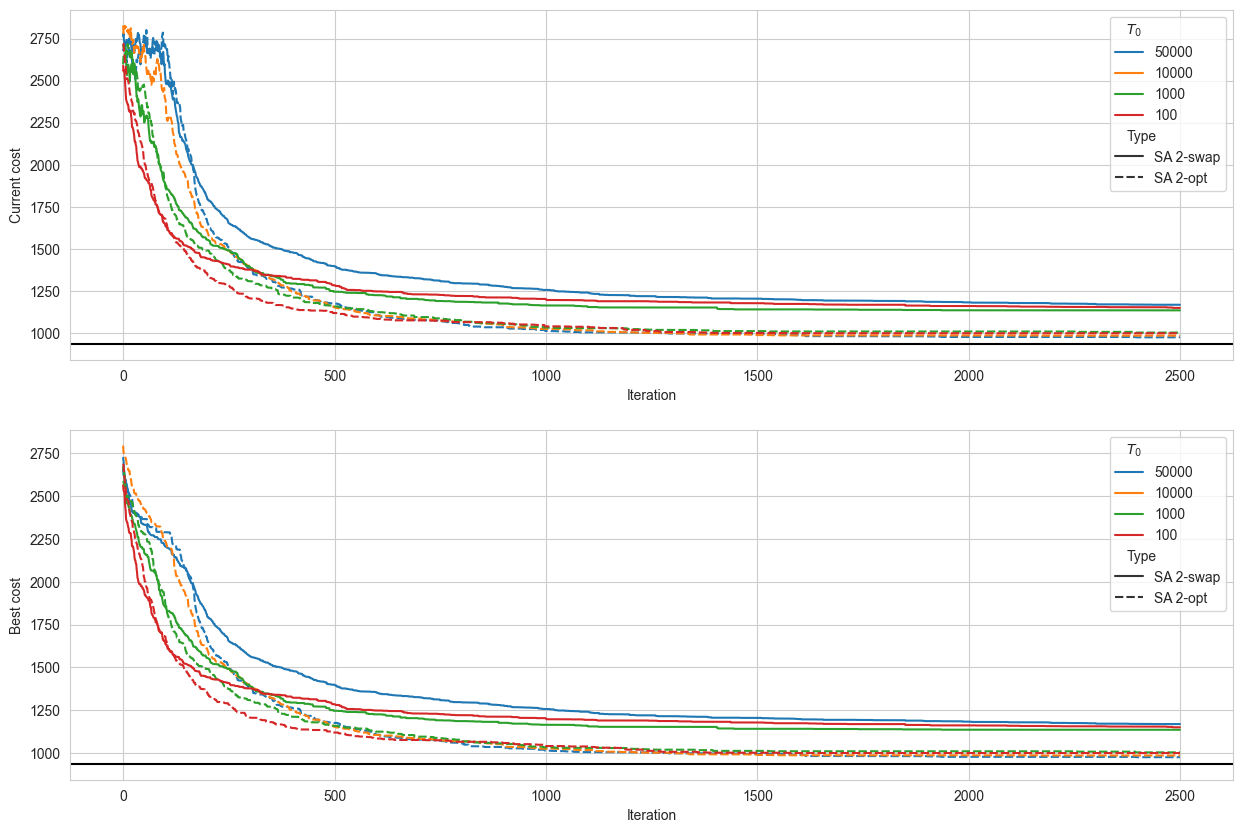

In [28]:
%%time
fri26_ne, _ = plot_wo_error(fri26_df, 937)
fri26_ne.savefig("../images/fri26-no-error.png", dpi=600, bbox_inches="tight")

/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

CPU times: user 25.8 s, sys: 203 ms, total: 26 s
Wall time: 24.9 s


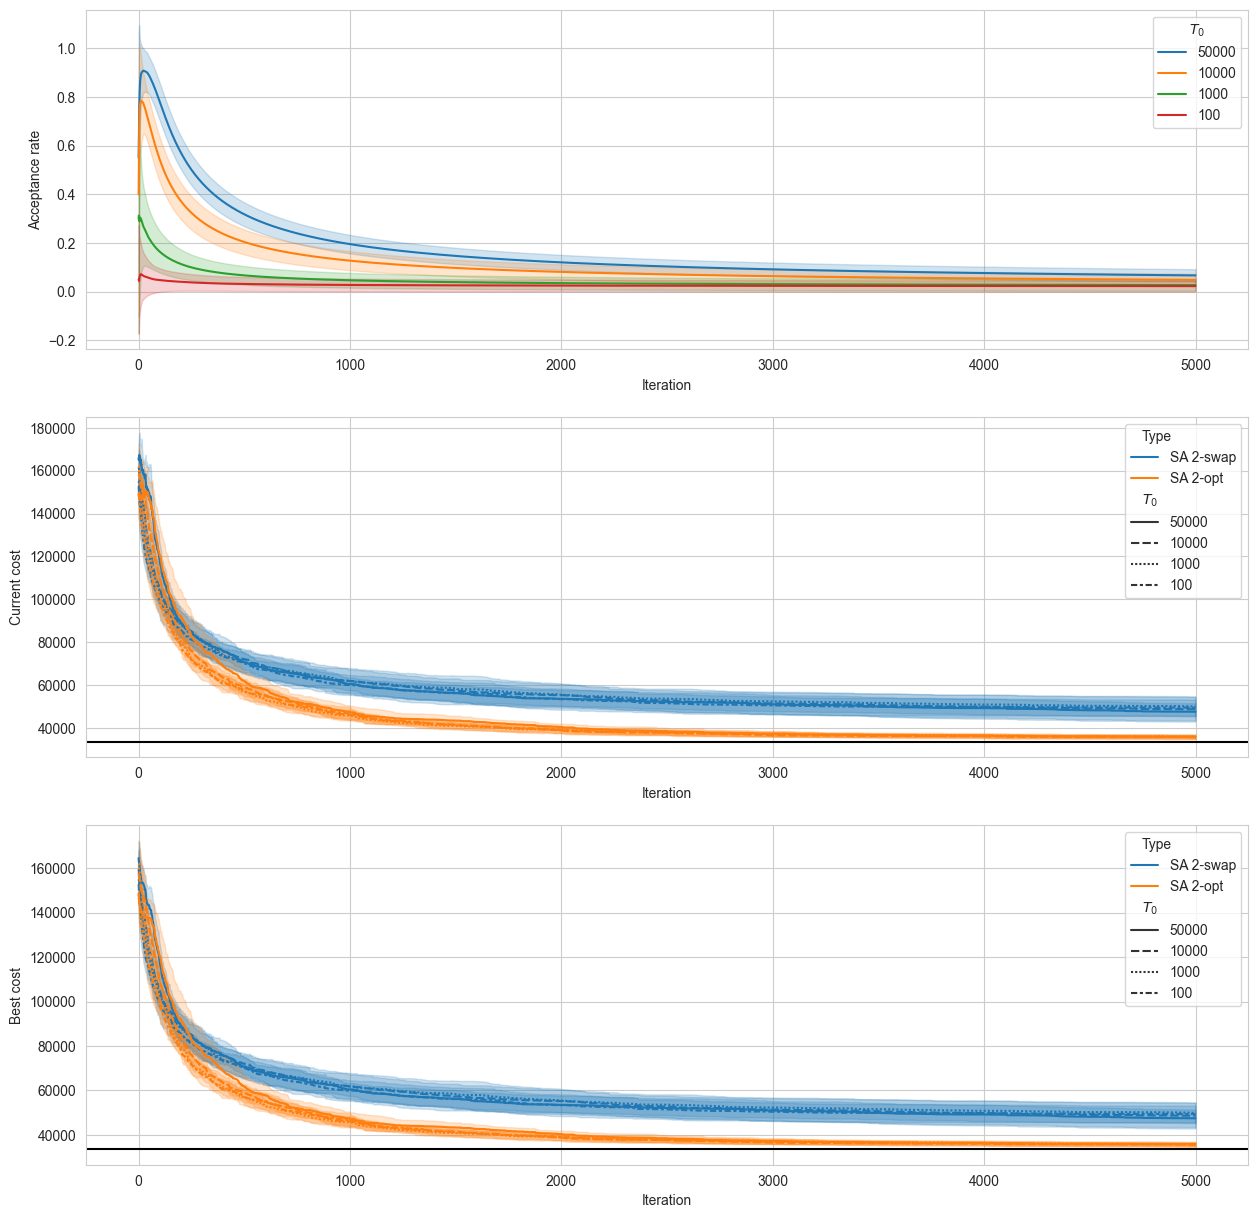

In [23]:
%%time
att48_fig, _ = plot(att48_df, 33523)
att48_fig.savefig("../images/att48_sa", dpi=600, bbox_inches="tight")

/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nawat/Library/Caches/pypoetry/virtualenvs/code-_T3AfWX0-p

CPU times: user 17.5 s, sys: 322 ms, total: 17.8 s
Wall time: 16.7 s


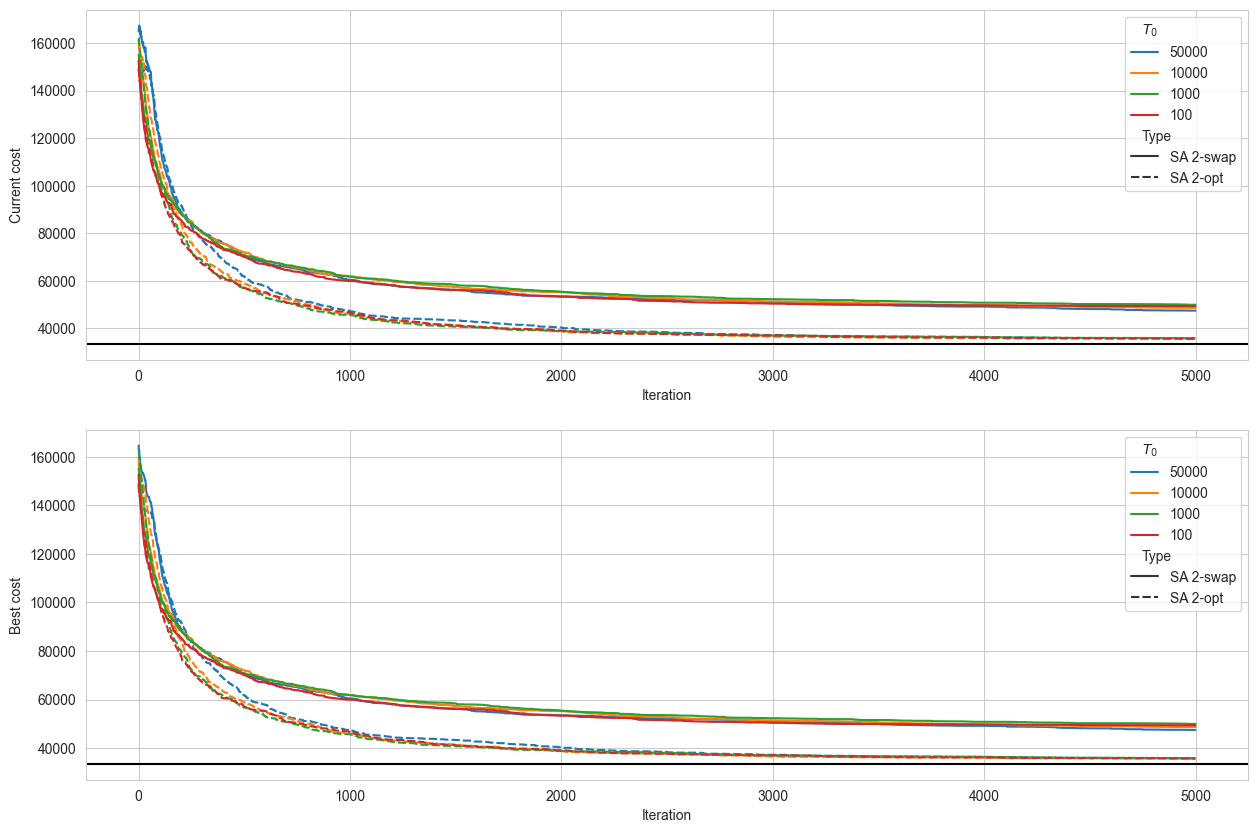

In [29]:
%%time
att48_ne, _ = plot_wo_error(att48_df, 33523)
att48_ne.savefig("../images/att48-no-error.png", dpi=600, bbox_inches="tight")

# Comparison with Hill Climbing

In [30]:
hc_gr17 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/gr17.csv")
hc_fri26 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/fri26.csv")
hc_att48 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/att48.csv")

sa_gr17 = pd.read_csv("results/sa_gr17.csv")
sa_fri26 = pd.read_csv("results/sa_fri26.csv")
sa_att48 = pd.read_csv("results/sa_att48.csv")

gr17 = pd.concat([sa_gr17[sa_gr17["$T_0$"] == "10000"], hc_gr17]) \
    .drop(["Current cost", "Acceptance rate", "Trial"], axis=1)
fri26 = pd.concat([sa_fri26[sa_fri26["$T_0$"] == "10000"], hc_fri26]) \
    .drop(["Current cost", "Acceptance rate", "Trial"], axis=1)
att48 = pd.concat([sa_att48[sa_att48["$T_0$"] == "10000"], hc_att48]) \
    .drop(["Current cost", "Acceptance rate", "Trial"], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nawat/muic/ma395_heuristic/homework/hw1/results/gr17.csv'

In [ ]:
plt.axhline(2085, color="black")
sns.lineplot(gr17, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/gr17-with-hc.png", dpi=600, bbox_inches="tight")

In [ ]:
plt.axhline(937, color="black")
sns.lineplot(fri26, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/fri26-with-hc.png", dpi=600, bbox_inches="tight")

In [ ]:
%%time
plt.axhline(33523, color="black")
sns.lineplot(att48, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/att48-with-hc.png", dpi=600, bbox_inches="tight")